# Анализ связи ключевых показателей игровой статистики с успешностью команды в профессиональном Counter-Strike

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

Подгружаем данные из таблицы в репозитории.

In [ ]:
data = pd.read_csv('https://github.com/Utukku/DataAnalysisProject/raw/refs/heads/main/dataset.csv')

Строим ГРАФИК-ЗАГЛУШКУ. Он здесь, чтобы файл с названием main не пустовал. Я в последний момент менял тему, и до графиков пока не дошёл. Но они будут!

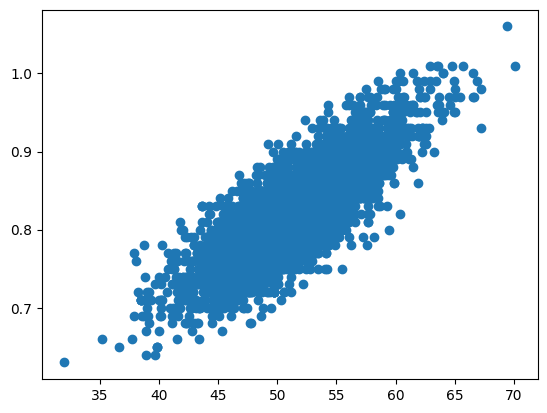

In [ ]:
plt.scatter(data.winrate, data.multikills)
